# Job Placement Dataset

Due to the growing need of educated and talented individuals, especially in developing countries, recruiting fresh graduates is a routine practice for organizations. Conventional recruiting methods and selection processes can be prone to errors and in order to optimize the whole process, some innovative methods are needed.

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from os import sep
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from numpy import mean
from sklearn.model_selection import cross_validate, train_test_split

In [4]:
FOLDER = 'otro'
PROJECT_NAME = 'acm women encourage'
PROJECTS_ROUTE = 'drive' + sep + 'MyDrive' + sep + FOLDER
START_PROJECT = PROJECTS_ROUTE + sep + PROJECT_NAME + sep
PATH_DATA_RAW = 'data' + sep

In [5]:
%cd $START_PROJECT

/content/drive/MyDrive/otro/acm women encourage


In [6]:
job_placement_data_raw = pd.read_csv(PATH_DATA_RAW + 'Job_Placement_Data.csv')

In [7]:
job_placement_data_raw.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


In [8]:
job_placement_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               215 non-null    object 
 1   ssc_percentage       215 non-null    float64
 2   ssc_board            215 non-null    object 
 3   hsc_percentage       215 non-null    float64
 4   hsc_board            215 non-null    object 
 5   hsc_subject          215 non-null    object 
 6   degree_percentage    215 non-null    float64
 7   undergrad_degree     215 non-null    object 
 8   work_experience      215 non-null    object 
 9   emp_test_percentage  215 non-null    float64
 10  specialisation       215 non-null    object 
 11  mba_percent          215 non-null    float64
 12  status               215 non-null    object 
dtypes: float64(5), object(8)
memory usage: 22.0+ KB


## DATA ANALYSIS

First, let's review the female and male sample number and also the status with respect to each gender.

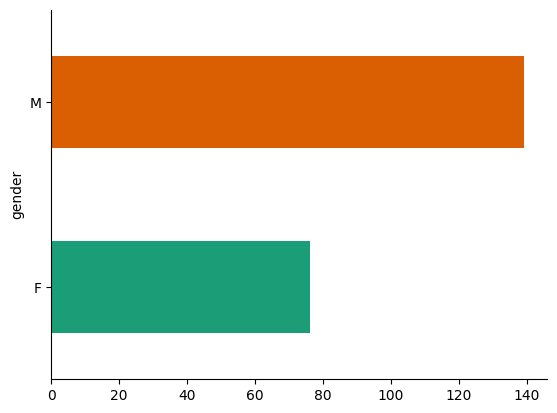

In [9]:
# Number of male samples vs female
job_placement_data_raw.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

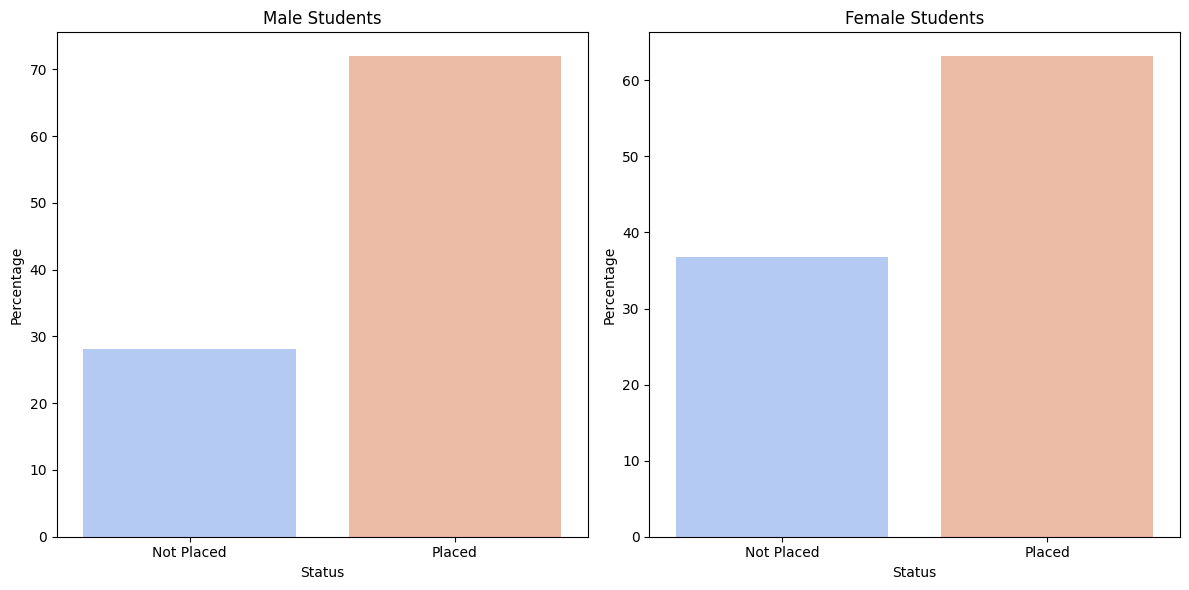

In [18]:
# Percentage of placed vs not placed for each gender
placement_counts = job_placement_data_raw.groupby(['gender', 'status']).size().unstack()
placement_percentage = placement_counts.div(placement_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for male
sns.barplot(x=placement_percentage.columns, y=placement_percentage.loc['M'], hue=placement_percentage.columns, ax=axs[0], palette='coolwarm', dodge=False)
axs[0].set_title('Male Students')
axs[0].set_ylabel('Percentage')
axs[0].set_xlabel('Status')

# Plot for female
sns.barplot(x=placement_percentage.columns, y=placement_percentage.loc['F'], hue=placement_percentage.columns, ax=axs[1], palette='coolwarm', dodge=False)
axs[1].set_title('Female Students')
axs[1].set_ylabel('Percentage')
axs[1].set_xlabel('Status')

plt.tight_layout()
plt.show()

From the previous plots, we can see that:
- The number of datapoints in the male populations is considerably higher than the number of datapoints in the female category, having the double of samples of males than females.
- The ratio of placed/not placed is considerably more favorable for the male students than for females.

## DATA PREPARATION

In this section we'll prepare the data so that the dataset can be ready for machine learning.

In [10]:
df1 = job_placement_data_raw.copy()

In [11]:
df1.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


### Check for missing values

There are no missing values, so no action is required

In [12]:
df1.isnull().sum(axis=1).sum()

0

### Encode categorical data

In order to be able to use some ml algorithms, we need to have all the columns encoded with numerical values.

In [13]:
# Get categorical columns
categorical_columns = df1.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['gender',
 'ssc_board',
 'hsc_board',
 'hsc_subject',
 'undergrad_degree',
 'work_experience',
 'specialisation',
 'status']

In [14]:
# Get the unique values for each categorical column
for column in categorical_columns:
  print(f"{column} unique values: {df1[column].unique()}")

gender unique values: ['M' 'F']
ssc_board unique values: ['Others' 'Central']
hsc_board unique values: ['Others' 'Central']
hsc_subject unique values: ['Commerce' 'Science' 'Arts']
undergrad_degree unique values: ['Sci&Tech' 'Comm&Mgmt' 'Others']
work_experience unique values: ['No' 'Yes']
specialisation unique values: ['Mkt&HR' 'Mkt&Fin']
status unique values: ['Placed' 'Not Placed']


### Binary one-hot encoding

We'll convert to binary the categorical columns that only have two possible values:
- Gender
- ssc_board
- hsc_board
- work_experience
- specialisation
- status

In [15]:
# Convert to biary
FEMALE_LABEL, MALE_LABEL = (0, 1)
OTHER_SSC_LABEL, CENTRAL_SSC_LABEL = (0, 1)
OTHER_HSC_LABEL, CENTRAL_HSC_LABEL = (0, 1)
NO_EXP_LABEL, EXP_LABEL = (0, 1)
HR_SPEC_LABEL, MKT_SPEC_LABEL = (0, 1)
PLACED_LABEL, NOT_PLACED_LABEL = (0, 1)

# Mapping for gender
gender_mapping = {'F': FEMALE_LABEL, 'M': MALE_LABEL}
df1['gender'] = df1['gender'].replace(gender_mapping)

# Mapping for ssc_board
ssc_board_mapping = {'Others': OTHER_SSC_LABEL, 'Central': CENTRAL_SSC_LABEL}
df1['ssc_board'] = df1['ssc_board'].replace(ssc_board_mapping)

# Mapping for hsc_board
hsc_board_mapping = {'Others': OTHER_HSC_LABEL, 'Central': CENTRAL_HSC_LABEL}
df1['hsc_board'] = df1['hsc_board'].replace(hsc_board_mapping)

# Mapping for work_experience
work_experience_mapping = {'No': NO_EXP_LABEL, 'Yes': EXP_LABEL}
df1['work_experience'] = df1['work_experience'].replace(work_experience_mapping)

# Mapping for specialisation
specialisation_mapping = {'Mkt&HR': HR_SPEC_LABEL, 'Mkt&Fin': MKT_SPEC_LABEL}
df1['specialisation'] = df1['specialisation'].replace(specialisation_mapping)

# Mapping for status
status_mapping = {'Placed': PLACED_LABEL, 'Not Placed': NOT_PLACED_LABEL}
df1['status'] = df1['status'].replace(status_mapping)

# Verify the changes
print(df1.head())

   gender  ssc_percentage  ssc_board  hsc_percentage  hsc_board hsc_subject  \
0       1           67.00          0           91.00          0    Commerce   
1       1           79.33          1           78.33          0     Science   
2       1           65.00          1           68.00          1        Arts   
3       1           56.00          1           52.00          1     Science   
4       1           85.80          1           73.60          1    Commerce   

   degree_percentage undergrad_degree  work_experience  emp_test_percentage  \
0              58.00         Sci&Tech                0                 55.0   
1              77.48         Sci&Tech                1                 86.5   
2              64.00        Comm&Mgmt                0                 75.0   
3              52.00         Sci&Tech                0                 66.0   
4              73.30        Comm&Mgmt                0                 96.8   

   specialisation  mba_percent  status  
0        

### Covert hsc_subject and undergrad_degree to numerical

Since we have more than two categories with no specific ordering, we'll use one-hot encodign to generate a new binary column for each categories

In [16]:
# Perform one-hot encoding for 'hsc_subject' column
hsc_subject_dummies = pd.get_dummies(df1['hsc_subject'], prefix='hsc_subject')
df1 = pd.concat([df1, hsc_subject_dummies], axis=1)
df1.drop('hsc_subject', axis=1, inplace=True)

# Perform one-hot encoding for 'undergrad_degree' column
undergrad_degree_dummies = pd.get_dummies(df1['undergrad_degree'], prefix='undergrad_degree')
df1 = pd.concat([df1, undergrad_degree_dummies], axis=1)
df1.drop('undergrad_degree', axis=1, inplace=True)

### Check all columns are numerical

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      215 non-null    int64  
 1   ssc_percentage              215 non-null    float64
 2   ssc_board                   215 non-null    int64  
 3   hsc_percentage              215 non-null    float64
 4   hsc_board                   215 non-null    int64  
 5   degree_percentage           215 non-null    float64
 6   work_experience             215 non-null    int64  
 7   emp_test_percentage         215 non-null    float64
 8   specialisation              215 non-null    int64  
 9   mba_percent                 215 non-null    float64
 10  status                      215 non-null    int64  
 11  hsc_subject_Arts            215 non-null    bool   
 12  hsc_subject_Commerce        215 non-null    bool   
 13  hsc_subject_Science         215 non

## BASELINE MODEL (NO DEBIASING)


In [19]:
def get_naive_dataset(dataset, random_state=4):
    data_shuffled = dataset.sample(frac=1, random_state=random_state).reset_index(drop=True)
    X = data_shuffled.drop(['status'], axis=1)
    y = data_shuffled['status']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
    return x_train, x_test, y_train, y_test

In [20]:
# For a baseline, we can use a simple model like Logistic Regression
model =  LogisticRegression(random_state=0, max_iter=2000)

X_train, X_test, y_train, y_test = get_naive_dataset(df1, 11)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)

In [21]:
test_df = pd.DataFrame(X_test, columns=df1.drop(columns=['status']).columns)
test_df['status'] = y_test
test_df['pred'] = y_pred
test_df['accurate'] = (test_df['pred'] == test_df['status'])
accuracy = test_df['accurate'].mean()
accuracy

0.8518518518518519

### Checking for gender bias

In [22]:
def evaluate_gender_performance(results_df):
    """
    Evaluate gender performance based on the results DataFrame.

    Args:
    - results_df: DataFrame containing results data.

    Returns:
    - summaries: Dictionary containing performance summaries.
    """
    summaries = {}

    # Overall accuracy
    overall_accuracy = results_df['accurate'].mean()
    summaries['accuracy_overall'] = overall_accuracy

    # Accuracy across gender
    for gender, gender_name in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df['gender'] == gender]
        accuracy_for_gender = rows['accurate'].mean()
        summaries['accuracy_' + gender_name] = accuracy_for_gender

    # Positive rates
    for gender, gender_name in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df['gender'] == gender]
        positive_rate_for_gender = (rows['pred'] == PLACED_LABEL).mean()
        summaries['positive_rate_' + gender_name] = positive_rate_for_gender

    # Negative rates
    for gender, gender_name in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df['gender'] == gender]
        negative_rate_for_gender = (rows['pred'] == NOT_PLACED_LABEL).mean()
        summaries['negative_rate_' + gender_name] = negative_rate_for_gender

    # True positive and True negative rates
    for index, (gender, gender_name) in enumerate([(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]):
        rows = results_df[results_df['gender'] == gender]
        placed = rows[rows['status'] == PLACED_LABEL]
        not_placed = rows[rows['status'] == NOT_PLACED_LABEL]
        true_positive_rate = placed['accurate'].mean()
        true_negative_rate = not_placed['accurate'].mean()
        summaries['true_positive_rate_' + gender_name] = true_positive_rate
        summaries['true_negative_rate_' + gender_name] = true_negative_rate


    return summaries

def plot_comparisons_groups(approaches, accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):
    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"

    indices = list(range(len(approaches)))
    colors = ['red', 'blue']
    fig, ax = plt.subplots()

    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index == 0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index == 0 else None)

    if labels:
        ax.legend()

    plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)

    plt.show()

def plot_model_gender_metrics(_feature, _summaries, _modelNames, _title, rotation='vertical'):
    gender_metrics = [[summary[_feature + '_Male'] for summary in _summaries],
                      [summary[_feature + '_Female'] for summary in _summaries]
                      ]
    plot_comparisons_groups(_modelNames, gender_metrics, _title, rotation=rotation)

def model_summary(model_name, title, summary):
    summaries = []
    model_names = []

    for key in ["accuracy", "positive_rate", "negative_rate", "true_positive_rate", "true_negative_rate"]:
        new_summary = {"accuracy_Male": summary[key + "_Male"], "accuracy_Female": summary[key + "_Female"]}
        summaries.append(new_summary)
        model_names.append(key)
    plot_model_gender_metrics("accuracy", summaries, model_names, model_name)


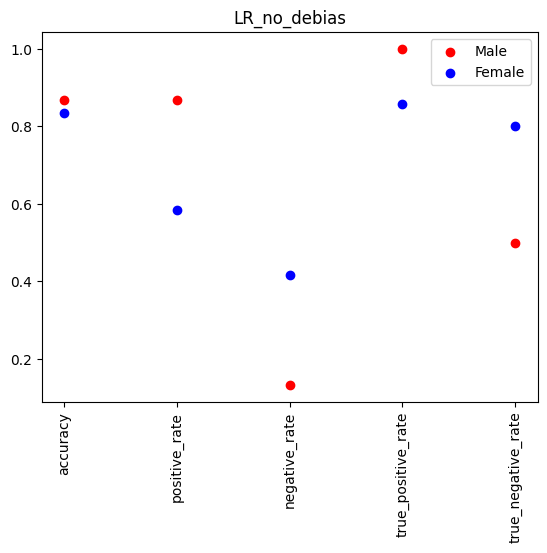

In [23]:
original_approach = evaluate_gender_performance(test_df)
model_summary("LR_no_debias", "", original_approach)

From the plot, we can see males have a higher placed rate, both in the points of true_placed_label and in placed_predicted_rate. Likewise, we see a higher not placed rate for females im both true_not_placed_label and in not_placed_predicted_rate.

Hence, we can see a predilection of the model of placing males and not placing females.

## APLYING BIAS MITIGATION TECHNIQUES

There are many data-based debiasing techniques which help reduce bias in our model's predictions:
- Mitigation through unawareness: removing the columns that may cause bias from the training set (gender in our case).
- Mitigation through dataset balancing:
  - Get equal number of datapoints per demographic
  - Get equal number of datapoints per demographic in each category
  - Get equal ratios per demographic
- Bias mitigation through data augmentation
  - Counterfactual augmentation

Since the dataframe we are using is very small, reducing is not a considerable solution. Hence, we will only try mitigation through awareness and data augmentation.

### Mitigation thorugh unawareness

In [24]:
def get_unawareness_dataset(dataset, random_state=4):
    x_train, x_test, y_train, y_test = get_naive_dataset(dataset, random_state)
    testdata = x_test.copy()
    assert "gender" in list(testdata.columns), ("columns: ", list(testdata.columns))

    x_train, x_test = [v.drop(['gender'], axis=1) for v in (x_train, x_test)]
    return x_train, x_test, y_train, y_test, testdata

In [25]:
def evaluate_predictor_performance(predictions, x_test, y_test):
    """
    Returns summary statistics for the predictor's performance

    Input:
        - predictions: model's predictions on x_test
        - x_test: test input
        - y_test: test labels

    Requires:
        - predictor must have been fitted on x_train and y_train from the same dataset

    Check method evaluate_gender_performance for more on the produced summary statistics
    """
    testdata = pd.DataFrame(x_test, columns=df1.drop(columns=['status']).columns)
    testdata['status'] = y_test
    testdata['pred'] = pd.Series(predictions, index=x_test.index)
    testdata['accurate'] = (testdata['pred'] == testdata['status'])
    return evaluate_gender_performance(testdata)

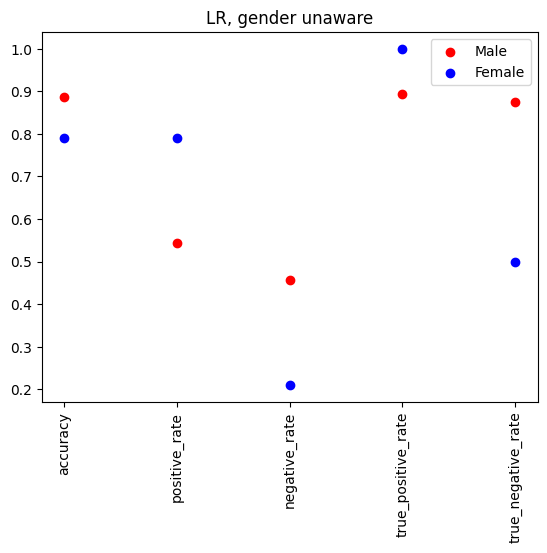

In [26]:
model = LogisticRegression(random_state=0, max_iter=800)

X_train, X_test, y_train, y_test, testdata = get_unawareness_dataset(df1, random_state=10)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
approach_1 = evaluate_predictor_performance(y_pred, testdata, y_test)
model_summary("LR, gender unaware", "", approach_1)

In this case, we see that this technique wasn't effective to reduce the gender bias in the metrics plotted.

This can be due to having some proxy features in the dataset that correlate with the gender attribute that we are dropping.

### Mitigation through data augmentation

In [27]:
def add_gender_counterfacts(df):
    df_out = df.copy()
    df_out['gender'] = df_out['gender'].apply(lambda value: 1-value)
    result = pd.concat([df.copy(), df_out])
    return result

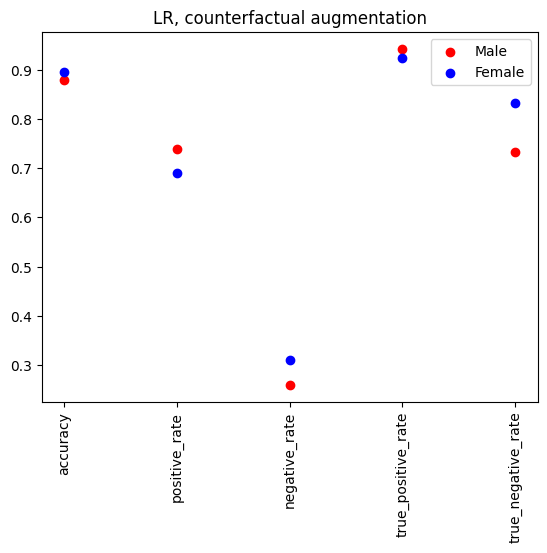

In [28]:
model = LogisticRegression(random_state=0, max_iter=1000)

gender_augmented_df1 = add_gender_counterfacts(df1)
X_train, X_test, y_train, y_test = get_naive_dataset(gender_augmented_df1, random_state=10)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
approach_1 = evaluate_predictor_performance(y_pred, X_test, y_test)
model_summary("LR, counterfactual augmentation", "", approach_1)

We see that although there are still more placed males than females, we have reduced the distance between the points with respect to the baseline. Hence, the bias has been reduced.

Now, with the gender balanced dataset, we can try also dropping the gneder feature to see if we can gian further improvements.

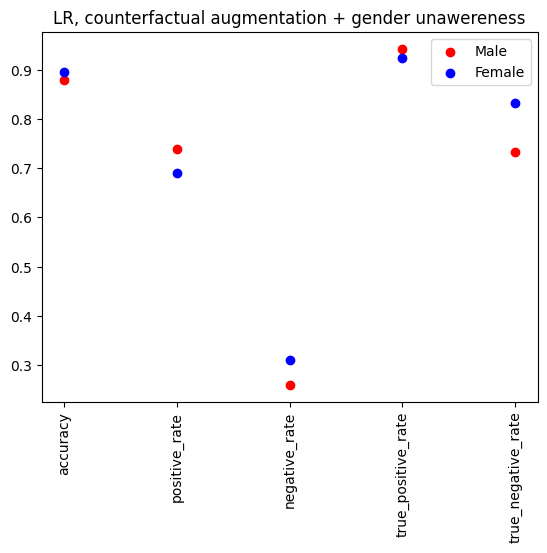

In [29]:
# Blind counterfactual augmentation
model = LogisticRegression(random_state=0, max_iter=1000)

gender_augmented_df1 = add_gender_counterfacts(df1)
X_train, X_test, y_train, y_test, testdata = get_unawareness_dataset(gender_augmented_df1, random_state=10)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
approach_1 = evaluate_predictor_performance(y_pred, testdata, y_test)
model_summary("LR, counterfactual augmentation + gender unawereness", "", approach_1)

Again, we see that dropping the gender column didn't give any improvements.

## BIAS MITIGATION THROUGH FAIR MODEL SELECTION

After applying bias mitigation techniques in the dataset, we can now explore different models to have more accurate predictions, while also considering the mitigation of gender bias.

In [30]:
# Create a list with all the algorithms to try
model_pipeline = []
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier(random_state=0))
model_pipeline.append(RandomForestClassifier(random_state=0))
model_pipeline.append(GaussianNB())
model_pipeline.append(XGBClassifier(objective="binary:logistic", random_state=0))

models = ['KNN Classifier','Decision Tree', 'Random Forest', 'Gaussian NB', 'Gradient Boosting']

# Separate data in inputs and output
X = gender_augmented_df1.drop(columns=['status']).values
y = gender_augmented_df1['status'].values

# Build CV Object & Model & Scoring
n_splits = 5 # default
skf = StratifiedKFold(n_splits)
scoring='accuracy'

# Evaluate each model
for idx, model in enumerate(model_pipeline):
    scores_skf = cross_validate(model, X, y, scoring=scoring, cv=skf, return_train_score=True)
    print(f'{models[idx]} Mean accuracy: ', mean(scores_skf['test_score']))

KNN Classifier Mean accuracy:  0.8744186046511627
Decision Tree Mean accuracy:  0.9953488372093023
Random Forest Mean accuracy:  1.0
Gaussian NB Mean accuracy:  0.8023255813953488
Gradient Boosting Mean accuracy:  1.0


The models that gave the best results are Decision Tree, Random Forest and Gradient boosting. Let's see how good they are in terms of bias mitigation.

### Decision Tree bias metrics

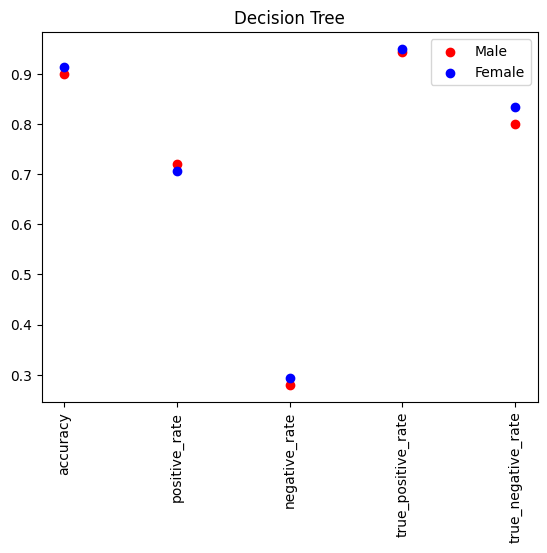

In [31]:
model = DecisionTreeClassifier(random_state=0)

X_train, X_test, y_train, y_test = get_naive_dataset(gender_augmented_df1, random_state=10)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
approach_1 = evaluate_predictor_performance(y_pred, X_test, y_test)
model_summary("Decision Tree", "", approach_1)

### Random Forest bias metrics

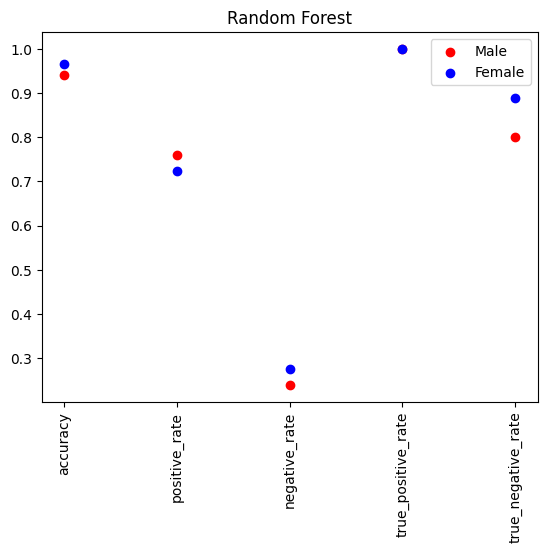

In [32]:
model = RandomForestClassifier(random_state=0)

X_train, X_test, y_train, y_test = get_naive_dataset(gender_augmented_df1, random_state=10)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
approach_1 = evaluate_predictor_performance(y_pred, X_test, y_test)
model_summary("Random Forest", "", approach_1)

### Gradient Boost bias metrics

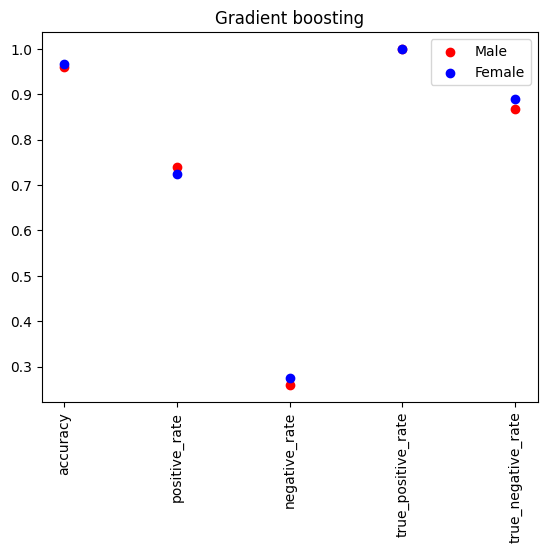

In [33]:
model = XGBClassifier(objective="binary:logistic", random_state=0)

X_train, X_test, y_train, y_test = get_naive_dataset(gender_augmented_df1, random_state=10)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
approach_1 = evaluate_predictor_performance(y_pred, X_test, y_test)
model_summary("Gradient boosting", "", approach_1)

From all the results presented, we can see that the best one is Gradient Boost, yielding a good accuracy metric and effectively mitigating the bias introduced by the gender imbalance observed initially in the dataframe.

## CONCLUSION

We were able to successfully train an unbiased model with a small dataframe with gender imbalance.

### Basline

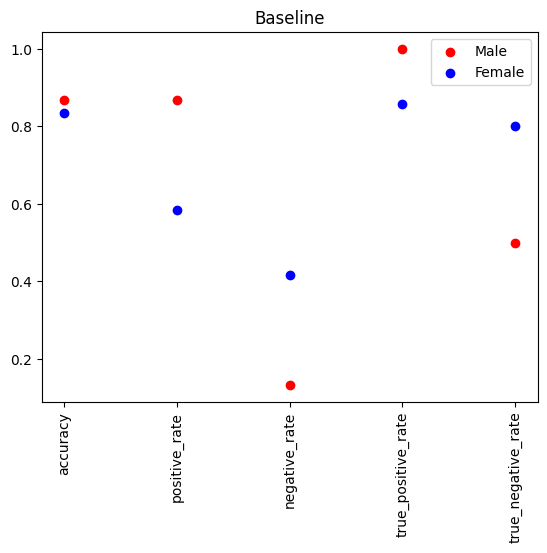

In [34]:
model = LogisticRegression(random_state=0, max_iter=800)

X_train, X_test, y_train, y_test = get_naive_dataset(df1, random_state=11)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
approach_1 = evaluate_predictor_performance(y_pred, X_test, y_test)
model_summary("Baseline", "", approach_1)

### Final Model

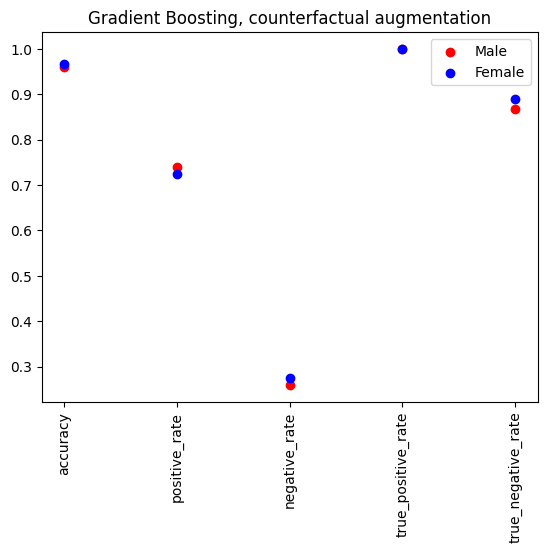

In [35]:
model = XGBClassifier(objective="binary:logistic", random_state=0)

X_train, X_test, y_train, y_test = get_naive_dataset(gender_augmented_df1, random_state=10)

# fit the model
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
approach_1 = evaluate_predictor_performance(y_pred, X_test, y_test)
model_summary("Gradient Boosting, counterfactual augmentation", "", approach_1)

Resources:

https://www.kaggle.com/datasets/ahsan81/job-placement-dataset?resource=download

https://ocw.mit.edu/courses/res-ec-001-exploring-fairness-in-machine-learning-for-international-development-spring-2020/pages/module-four-case-studies/case-study-mitigating-gender-bias/

https://github.com/heyaudace/ml-bias-fairness/tree/master
